In [1]:
import datetime
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import demandlib.bdew as bdew
from datetime import time as settime
import demandlib.particular_profiles as profiles

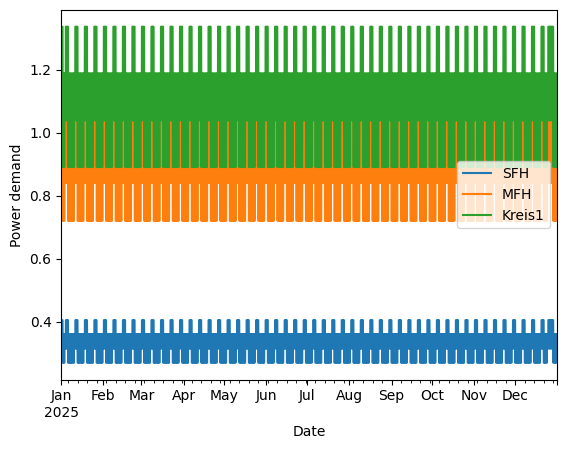

In [2]:
holidays = {
    datetime.date(2025, 1, 1): "New year",
    datetime.date(2025, 12, 25): "Christmas Day",
    datetime.date(2025, 12, 26): "Second Christmas Day",
}

ann_el_demand_per_sector = {
    "SFH": 3000,
    "MFH": 8000,
    "Kreis1": 10000
}

year = 2025

# read standard load profiles
e_slp = bdew.ElecSlp(year, holidays=holidays)

# multiply given annual demand with timeseries
elec_demand = e_slp.get_profile(ann_el_demand_per_sector)

# Add the slp for the industrial group
ilp = profiles.IndustrialLoadProfile(e_slp.date_time_index, holidays=holidays)


# Set beginning of workday to 8 am
elec_demand["SFH"] = ilp.simple_profile(ann_el_demand_per_sector["SFH"], am=settime(8, 0, 0))
elec_demand["MFH"] = ilp.simple_profile(ann_el_demand_per_sector["MFH"], am=settime(8, 0, 0))
elec_demand["Kreis1"] = ilp.simple_profile(ann_el_demand_per_sector["Kreis1"])

# # Change scaling factors
# elec_demand["i2"] = ilp.simple_profile(
#     ann_el_demand_per_sector["i2"],
#     profile_factors={
#         "week": {"day": 1.0, "night": 0.8},
#         "weekend": {"day": 0.8, "night": 0.6},
#         "holiday": {"day": 0.6, "night": 0.4},
#     },
# )

# Resample 15-minute values to hourly values.
elec_demand_resampled = elec_demand.resample("h").mean()

# Plot demand
ax = elec_demand_resampled.plot()
ax.set_xlabel("Date")
ax.set_ylabel("Power demand")
plt.show()

elec_demand_resampled.to_csv("elec_demand.csv")

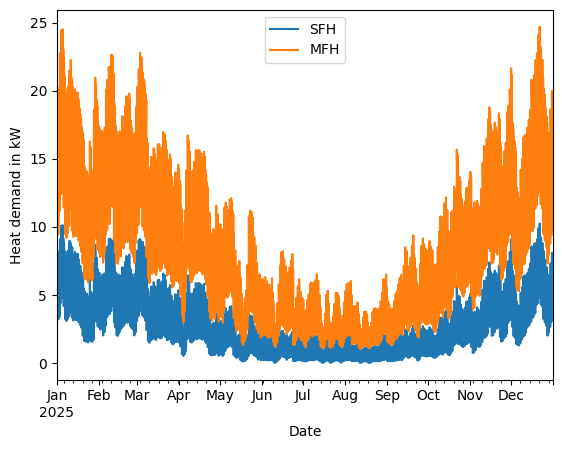

In [3]:
# read example temperature series
filename = "example_data.csv"
dirname = os.getcwd()
datapath = os.path.join(dirname, filename)

if not os.path.isfile(datapath):
    msg = (
        "The file {0} could not be found in the current working directory.\n "
        "This could happen due to the following reasons:\n"
        "* you forgot to download the example data from the repository\n"
        "* the filename is wrong\n"
        "* the file is not located in {1}\n"
        "Download the file from the demandlib repository and copy it to the "
        "right directory.\nAlternatively you can adapt the name of the file "
        "or the name of the directory in the example script."
    )
    print(msg.format(filename, dirname))
    exit(0)

temperature = pd.read_csv(datapath)["temperature"]


# The following dictionary is create by "workalendar"
# pip3 install workalendar
# >>> from workalendar.europe import Germany
# >>> cal = Germany()
# >>> holidays = dict(cal.holidays(2010))


ann_demands_per_type = {"SFH": 25000, "MFH": 80000}



# Create DataFrame for 2025
demand = pd.DataFrame(
    index=pd.date_range(
        datetime.datetime(2025, 1, 1, 0), periods=8760, freq="h"
    )
)

# Single family house (SFH: Einfamilienhaus)
demand["SFH"] = bdew.HeatBuilding(
    demand.index,
    holidays=holidays,
    temperature=temperature,
    shlp_type="efh",
    building_class=1,
    wind_class=1,
    annual_heat_demand=ann_demands_per_type["SFH"],
    name="SFH",
).get_bdew_profile()

# Multi family house (MFH: Mehrfamilienhaus)
demand["MFH"] = bdew.HeatBuilding(
    demand.index,
    holidays=holidays,
    temperature=temperature,
    shlp_type="mfh",
    building_class=2,
    wind_class=0,
    annual_heat_demand=ann_demands_per_type["MFH"],
    name="MFH",
).get_bdew_profile()

# Plot demand of building
ax = demand.plot()
ax.set_xlabel("Date")
ax.set_ylabel("Heat demand in kW")
plt.show()

for key in ann_demands_per_type:
    assert np.isclose(demand[key].sum(), ann_demands_per_type[key], rtol=1e-4)

demand.to_csv("heat_demand.csv")

In [4]:
vector = []
for col in demand.columns:
    vector.append([
        {
            "Type": "Local demand",
            "Commodity": "Heat",
            "Building": col if col != "Kreis1" else None,
            "District": col if col == "Kreis1" else "All",
            "Unit": None
        },
        [{"start": demand.index.strftime("%Y-%m-%dT%H:%M:%S")[0], "repeat": False, "ignore_year": True, "resolution": "1h"},
            demand[col].round(3).tolist()
        ],
        'time_series'
    ]
    )

for col in elec_demand_resampled.columns:
    vector.append([
        {
            "Type": "Local demand",
            "Commodity": "Electricity",
            "Building": col if col != "Kreis1" else None,
            "District": col if col == "Kreis1" else "All",
            "Unit": None
        },
        [{"repeat": False, "ignore_year": True},
            dict(zip(elec_demand_resampled.index.strftime("%Y-%m-%dT%H:%M:%S"), elec_demand_resampled[col].round(3)))
        ],
        'time_series'
    ]
    )

In [5]:
# put the vector in a json file
import json
with open("demand.json", "w") as f:
    json.dump(vector, f, indent=4)

In [19]:
# import math

# x = [i for i in range(0, 24)]
# y = [0 if i < 8 or i > 18 else math.sin(math.radians((i-8)*15)) for i in x]
# plt.plot(x, y)
# # to csv
# pd.DataFrame(y, index=x).to_csv("solar.csv")